[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ryansteed/image-gpt-bias/blob/master/notebooks/simclr.ipynb)

In [2]:
# inspired by 
# https://colab.research.google.com/github/google-research/simclr/blob/master/colabs/finetuning.ipynb#scrollTo=Ih5NlvdDEOI1
# https://github.com/sayakpaul/SimCLR-in-TensorFlow-2/blob/master/Linear_Evaluation_Imagenet_Subset.ipynb
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()
import tensorflow_hub as hub
import os
from tqdm import tqdm
import numpy as np
import cv2
import matplotlib.pyplot as plt

depth = 50 #50, 101, 152
width = 1 #1, 2, 3
sk = 0 #0, 1

# %cd /Users/steed/caliskan/git/image-gpt-bias

In [3]:
import urllib

# don't share these to Github or elsewhere!
u = "your_username"
p = urllib.parse.quote("your_password")
!git clone --recurse-submodules -j8 https://$u:$p@github.com/$u/image-gpt-bias.git
%cd image-gpt-bias

Cloning into 'image-gpt-bias'...
remote: Enumerating objects: 19, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 1408 (delta 4), reused 14 (delta 3), pack-reused 1389
Receiving objects: 100% (1408/1408), 103.51 MiB | 34.48 MiB/s, done.
Resolving deltas: 100% (299/299), done.
Submodule 'image-gpt' (https://github.com/openai/image-gpt) registered for path 'image-gpt'
Submodule 'weat' (https://github.com/ryansteed/weat) registered for path 'weat'
Cloning into '/content/image-gpt-bias/image-gpt'...
remote: Enumerating objects: 41, done.        
remote: Total 41 (delta 0), reused 0 (delta 0), pack-reused 41        
Cloning into '/content/image-gpt-bias/weat'...
remote: Enumerating objects: 85, done.        
remote: Counting objects: 100% (85/85), done.        
remote: Compressing objects: 100% (59/59), done.        
remote: Total 85 (delta 25), reused 74 (delta 17), pack-reused 0        
Submodule path 'image-gpt': checked 

In [4]:
hub_path = f"gs://simclr-checkpoints/simclrv2/pretrained/r{depth}_{width}x_sk{sk}/hub"
module = hub.Module(hub_path, trainable=False)

In [8]:
# preprocess images
test_dir = "data/experiments/weapon"
image_paths = [os.path.join(test_dir, d, f) for d in os.listdir(test_dir) for f in os.listdir(os.path.join(test_dir, d))]
image_paths[0]

'data/experiments/weapon/tool/phone.jpg'

100%|██████████| 44/44 [00:00<00:00, 70.45it/s]

(44, 224, 224, 3)


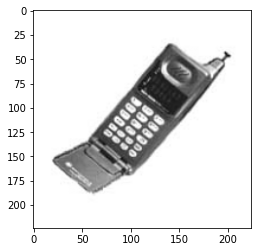

In [9]:
# need some help on turning these into tensors for preprocessing
# using https://github.com/sayakpaul/SimCLR-in-TensorFlow-2/blob/master/SimCLR_ImageNet_Subset.ipynb
def prepare_images(image_paths):
    images = []

    for image in tqdm(image_paths):
        image_pixels = plt.imread(image)
        image_pixels = cv2.resize(image_pixels, (224, 224))
        image_pixels = image_pixels/255.

        images.append(image_pixels)

    images = np.array(images)
    print(images.shape)

    return images

images = prepare_images(image_paths)
plt.imshow(images[0])

In [10]:
# get the final average pool
key = module(inputs=images, signature="default", as_dict=True)
key

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


{'default': <tf.Tensor 'module_apply_default/base_model/final_avg_pool:0' shape=(44, 2048) dtype=float32>,
 'logits_sup': <tf.Tensor 'module_apply_default/head_supervised/linear_layer/linear_layer_out:0' shape=(44, 1000) dtype=float32>,
 'proj_head_input': <tf.Tensor 'module_apply_default/base_model/final_avg_pool:0' shape=(44, 2048) dtype=float32>,
 'proj_head_output': <tf.Tensor 'module_apply_default/head_contrastive/nl_2/nl_2_out:0' shape=(44, 128) dtype=float32>}

In [11]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [14]:
output = key['default'].eval(session=sess)
output.shape

(44, 2048)